# Changing the Game: Reward Shaping

In this notebook:

- An introduction to reward shaping
- Various visualizations of training runs
- Small tweak to a heuristic from the [original paper](https://people.eecs.berkeley.edu/~pabbeel/cs287-fa09/readings/NgHaradaRussell-shaping-ICML1999.pdf) on potential based reward shaping

I wrote a little library to help run all the experiments and make visualizations, which you can find [here](https://github.com/dylwil3/reward-shaping). Please feel free to write an issue or make a PR if you have questions or suggestions!

tl;dr/"abstract":

Sometimes changing the reward function helps speed up or stabilize training in RL- but beware changing the true goal! *Potential based reward shaping* guarantees that the policy remains unchanged even as the rewards are modified. We find that, unlike what is suggested in the original paper, it may be more helpful to choose a potential that underestimates the optimal state value function. We offer a plausible explanation for this in the case of Q-learning initialized at zero.

## Introduction

Players need feedback in order to improve. In a game with sparse or infrequent rewards, learning can go slowly. We can see this in the classic example of the [Frozen Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/). In this game, the player must traverse a frozen lake, avoiding holes, in order to reach a goal. The reward at each step is +0 unless the player has reached the goal, in which case the reward is +1; falling in a hole terminates the episode.

<img src = "assets/frozen-lake.png">

Below, we display the typical number of timesteps it takes before a Q-learning agent updates their value estimate at a given square.

In [1]:
# Notebook setup

# Imports
import reward_shaping as rs
import gymnasium as gym

# Constants
RUNS = 200  # Number of times we run each experiment
SMALL_MAP_SIZE = 4  # Size of small frozen lake map
LARGE_MAP_SIZE = 8  # Size of large frozen lake map
SMALL_EPISODES = 500  # Episodes per run to train on small lake
LARGE_EPISODES = 2000  # Episodes per run to train on large lake


# Helper function to display timestep that state value is updated during run (on average)
def display_frozen_updates(exp: rs.Experiment, map_size: int):
    values = exp.dm.value_update_timesteps
    ax, n_finite_runs, total_runs = rs.visualize_frozen_updates(values, map_size)
    ax.collections[0].set_clim(500, 1200)
    # print(
    # f"""This plot uses data from the {n_finite_runs}/{total_runs}
    # runs that updated the value of the initial state."""
    # )
    return ax


small_lake_params = {
    "env_id": "FrozenLake-v1",
    "env_options": {
        "desc": None,
        "is_slippery": False,
        "map_name": "4x4",
    },
}

small_q_learner_params = {
    "lr": 0.7,
    "eps_init": 1,
    "eps_final": 0.1,
    "eps_decay": 0.0005,
    "discount": 0.95,
    "action_space": gym.spaces.Discrete(4),
}

pygame 2.4.0 (SDL 2.26.4, Python 3.9.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Run first experiment

exp = rs.Experiment(
    "ExampleSmallLake", **small_lake_params, q_learner_params=small_q_learner_params
)
exp.run(runs=RUNS, episodes_per_run=SMALL_EPISODES)

100%|██████████| 200/200 [03:56<00:00,  1.18s/it]


<Axes: title={'center': 'Timesteps before Updating Value'}>

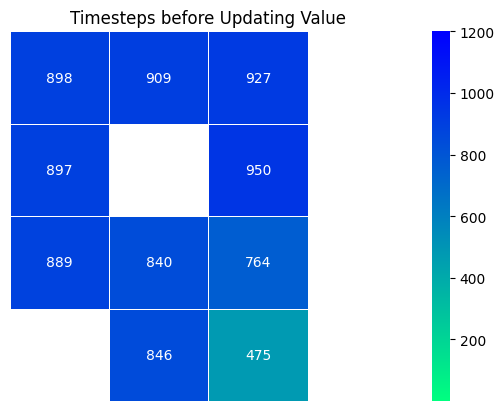

In [3]:
display_frozen_updates(exp, SMALL_MAP_SIZE)

And that is just to update the Q-value at all; if we want to actually converge to an optimal policy, it takes longer. Here is a visualization of how training usually goes, using the same hyperparameters as above.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

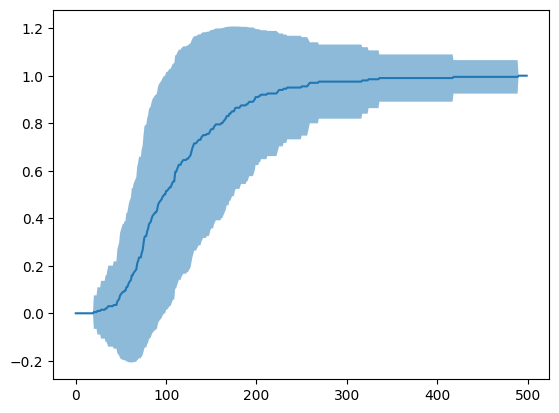

In [4]:
# Plot average training run evaluations, with shaded standard deviation.
exp.plot_evals()

In this notebook we'll begin exploring one possibility for handling sparse rewards: changing the reward function, also called **reward shaping**. 

## Some Care Required

One of the simplest pieces of additional feedback we could give our agent traversing the frozen lake is "You're getting closer!"

Specifically, we could award the agent some amount for moving in the direction of the goal. Let's try it! Here's the visualization of how long it takes to update:

In [5]:
# Run 'Getting Closer' experiment


def frozen_distance_to_goal_function(map_size: int) -> callable:
    """For a given map si"""

    def thunk(x):
        return abs(x // map_size - (map_size - 1)) + abs(
            (x % map_size) - (map_size - 1)
        )

    return thunk


exp = rs.Experiment(
    name="ExampleGettingCloser",
    **small_lake_params,
    q_learner_params=small_q_learner_params,
    modification=rs.RewardGettingCloser,
    modification_params={
        "dist_to_goal": frozen_distance_to_goal_function(SMALL_MAP_SIZE)
    },
)

exp.run(runs=20, episodes_per_run=500)

100%|██████████| 20/20 [00:43<00:00,  2.20s/it]


<Axes: title={'center': 'Timesteps before Updating Value'}>

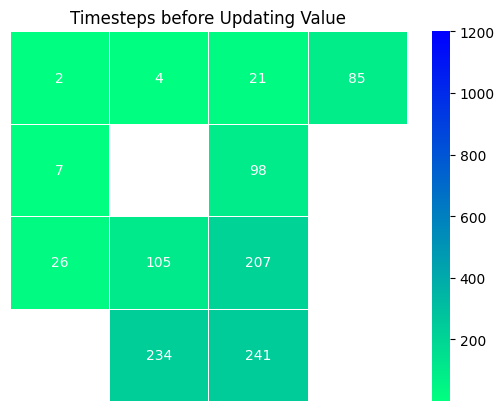

In [6]:
display_frozen_updates(exp, SMALL_MAP_SIZE)

Looks better! We update our Q-table values much earlier. Let's see how our agent does on the game throughout training.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

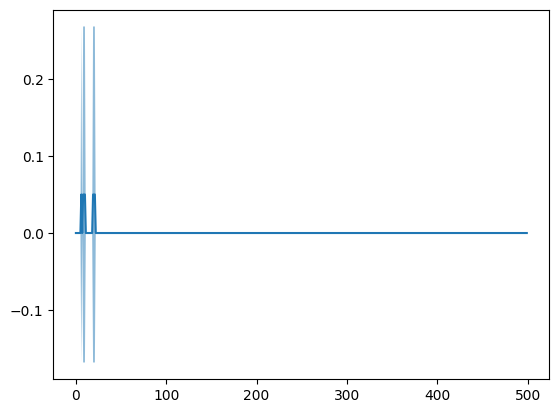

In [7]:
exp.plot_evals()

Whoa. What happened here? Maybe a video of the gameplay will shed some light on what's going on.

In [ ]:
exp.record_video()

<video controls src="logs/experiment_ExampleGettingCloser/rl-video-episode-0.mp4">

Ah! The agent has discovered an easy way to get lots of points: just keep going back and forth until the end of the episode. We have run into a fundamental issue in reinforcement learning: how do we know that policies which are optimal for some reward function are aligned with our true goal?

Well, we don't know how to answer that question in general, but it turns out we can completely answer a related question: when does the set of optimal policies remain unchanged after modifying the reward function? 

## Potential Based Reward Shaping
About 25 years ago, [Ng-Haradad-Russell]() gave a precise answer to this question. After replacing a reward function $R$ by a new one $R_{\text{new}}$, they prove that the set of optimal policies is unchanged if and only if there is a function $\Phi$ on the set of states such that:
$$
(R_{\text{new}} - R)(s,a,s') = \gamma\Phi(s') - \Phi(s)
$$
Here $\gamma$ is the discount factor used in evaluating your policy, and $\Phi$ is often called the **potential** function.

If we imagine that $\Phi$ records an approximation of the 'potential value' of a state, then we are giving the agent *positive* feedback if it moves in the direction of more potential value and, importantly, giving the agent *negative* feedback if it moves in the direction of less potential value. The latter part is the key difference from our earlier attempt.

In the cited paper, the authors make the following argument for choosing $\Phi$ to approximate the value of the state for the optimal policy. Let $M$ denote our original game and $M'$ denote the game with our modified reward function. First the authors show that

$$
V^*_{M'}(s) = V^*_M(s) - \Phi(s).
$$

If we take $\Phi(s) = V^*_M(s)$, then the value of each state in the new game is zero. The authors then state the following:

- **Heuristic**: It is easier to learn a game with optimal (discounted) value function zero.

In the paper, the authors show that this heuristic works well in gridworld examples where the (unmodified) reward penalizes the player at each time step Let's see how the heuristic plays out in our example.

### Frozen Lake Revisited

How can we approximate the (discounted) value function for the optimal policy on the frozen lake before we actually know the optimal policy? Well, if there were no holes, then, on the 4 by 4 map, it would take $|x-3|+|y-3|$ steps to get from $(x,y)$ to the goal. So the value of that state would be $\gamma^{|x-3|+|y-3|}$.

We will use this as our approximation, and hope the hole locations don't cause it to be too far off. In other words, we will take

$$
\Phi (s) = \gamma^{\text{Distance}(s,\text{goal})}
$$

where the distance is the 'taxicab' or 'Manhattan' distance on the grid.

In [3]:
# First experiment with potential based reward shaping.
def frozen_potential_function(map_size: int, discount: float) -> callable:
    def thunk(s):
        distance_to_goal = abs(s // map_size - (map_size - 1)) + abs(
            (s % map_size) - (map_size - 1)
        )
        return discount**distance_to_goal

    return thunk


In [ ]:


exp = rs.Experiment(
    "ExampleSmallPBRS",
    **small_lake_params,
    q_learner_params=small_q_learner_params,
    modification=rs.PBRS,
    modification_params={
        "potential": frozen_potential_function(
            SMALL_MAP_SIZE, small_q_learner_params["discount"]
        ),
        "discount": small_q_learner_params["discount"],
    }
)

exp.run(runs=RUNS, episodes_per_run=SMALL_EPISODES)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

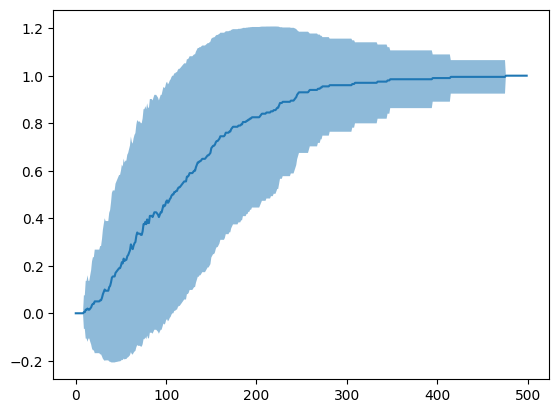

In [10]:
exp.plot_evals()

It... doesn't actually look that much better. Huh. That's a bit of a let down. Did we do something wrong? What do our update timesteps look like?

<Axes: title={'center': 'Timesteps before Updating Value'}>

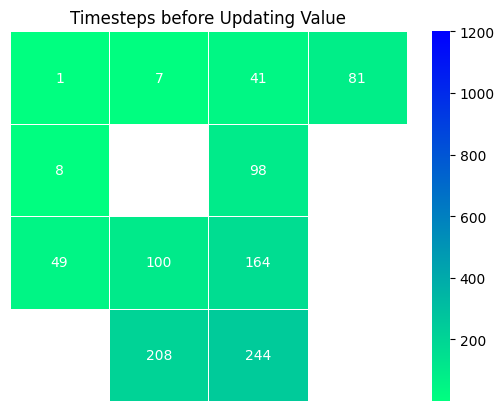

In [11]:
display_frozen_updates(exp, SMALL_MAP_SIZE)

Looks okay. Maybe the small lake is too easy so we can't see the difference. How about a bigger lake? Let's try the 8x8 Frozen Lake. The map looks like this:

<img src='assets/frozen-lake-8x8.png'>

Here's a baseline experiment vs one with potential based reward shaping.

In [2]:
# Big lake baseline
big_lake_params = {
    "env_id": "FrozenLake-v1",
    "env_options": {
        "desc": None,
        "is_slippery": False,
        "map_name": "8x8",
    },
}

big_q_learner_params = {
    "lr": 0.7,
    "eps_init": 1,
    "eps_final": 0.1,
    "eps_decay": 0.0005,
    "discount": 0.95,
    "action_space": gym.spaces.Discrete(4),
}


100%|██████████| 200/200 [28:28<00:00,  8.54s/it]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

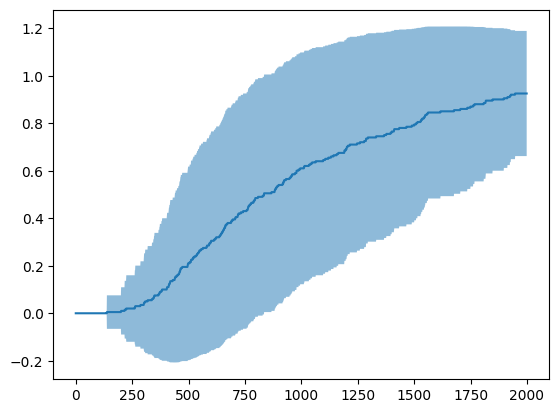

In [3]:

exp = rs.Experiment(
    "ExampleLargeLake",
    **big_lake_params,
    q_learner_params=big_q_learner_params,
)
exp.run(runs=RUNS, episodes_per_run=LARGE_EPISODES)
exp.plot_evals()

100%|██████████| 200/200 [26:29<00:00,  7.95s/it]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

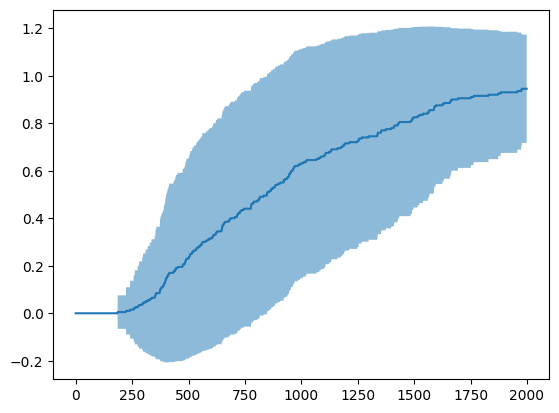

In [13]:
# Large lake with PBRS
big_q_learner_params_mod = {
    "lr": 0.7,
    "eps_init": 1,
    "eps_final": 0.1,
    "eps_decay": 0.0005,
    "discount": 0.95,
    "action_space": gym.spaces.Discrete(4),
}

exp = rs.Experiment(
    "ExampleLargePBRS",
    **big_lake_params,
    q_learner_params=big_q_learner_params,
    modification=rs.PBRS,
    modification_params={
        "discount": big_q_learner_params["discount"],
        "potential": frozen_potential_function(
            LARGE_MAP_SIZE, big_q_learner_params["discount"]
        ),
    }
)
exp.run(runs=RUNS, episodes_per_run=LARGE_EPISODES)
exp.plot_evals()

They look almost identical! What gives?

### Digression: Encouragement Matters

There didn't seem to be any improvement when we used PBRS on the Frozen Lake. Why is that? And why did it work when we were in the gridworld scenario?

Remember that we have been choosing our potentials motivated by:

- **Heuristic**: It's easy to learn a game with optimal value function 0.

Why would that be the case? Well, one could argue that if we initialize our Q-table to zero then that means that $Q(s,a)$ is already correct when $a$ is the optimal action. So, while learning, we have fewer updates to make before we arrive at the optimal Q-function.

To see the problem with this reasoning, imagine we are in a game with only one state and a large number of actions, $a_0, a_1, ..., a_{100}$ (i.e. a 100-armed bandit!). Suppose the optimal $Q$-function happened to look like:

$$
Q^*(a) = \begin{cases} 0 & a=a_{100}\\ -1 & \text{else} \end{cases}.
$$

Now imagine learning this game if we initialize our $Q$-function to zero. Every time we pick the non-optimal action, our $Q$-table updates to remove that action from consideration. But all the remaining actions look equally good to our learner! If the learner happens to choose the correct action, no update occurs because the $Q$-value is already correct, and the learner may as well have never taken that action.

If instead our optimal $Q$-function looked like:

$$
Q^*(a) = \begin{cases} 1 & a=a_{100}\\ -1 & \text{else} \end{cases},
$$

then, as soon as our learner chooses $a_{100}$ once during exploration, they'll adopt the optimal strategy!

**Remark**: Our implementation of Q-learning (which is quite standard) is to make the on-policy action as $\argmax_a Q(s,a)$ where, by convention, the actions are ordered in some way and this returns the *first* action $a$ that maximizes the function. We have to do something like this if we want a deterministic policy. 

For the first multi-armed bandit example, this implementation *always* has us perform the incorrect action until we have performed each of $a_0, ..., a_{99}$. In the Frozen Lake something like this happens as well: as an artifact of the indexing, the actions for DOWN (1) and RIGHT (2) come after LEFT (0), but are usually the directions one wants to travel to get to the goal. If one didn't care about having a deterministic policy during evaluation, one could mitigate this issue by sampling randomly from all actions $a$ with $Q(s,a)$ maximal. Nevertheless, the discussion of the multi-armed bandit above still applies when the action space is large.

Given the above discussion, I propose an alternative:

- **Updated Heuristic**:  (Assuming standard Q table initialization) try to choose a potential $\Phi(s)$ which is close to but *slightly smaller than* the optimal value of the state $s$. Ideally, so that $Q^*(s,a) - \Phi(s)$ is positive exactly for those actions $a$ which maximize $Q^*(s,-)$.

Let's experiment!


### Frozen Lake Revisited Revisited

The simplest way to implement our updated heuristic without changing too much of our approach is to choose some number $0< \varphi < \gamma < 1$ and make our potential

$$
\Phi(s) = \varphi^{\text{Distance}(s,\text{goal})}.
$$

So let's set $\varphi = \gamma/2$ and see how it goes.

100%|██████████| 200/200 [29:15<00:00,  8.78s/it]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

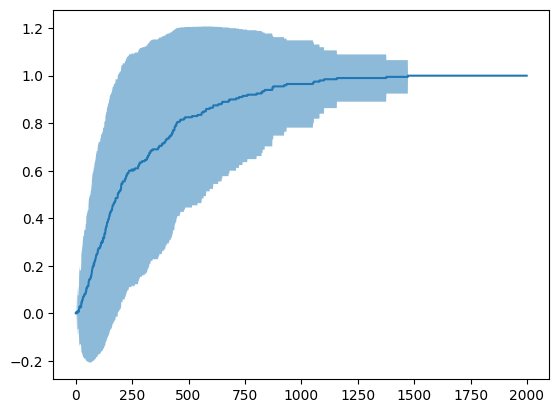

In [14]:
# Large frozen lake with modified potential
exp = rs.Experiment(
    "ExampleBigPBRSModified",
    **big_lake_params,
    q_learner_params=big_q_learner_params,
    modification=rs.PBRS,
    modification_params={
        "potential": frozen_potential_function(
            LARGE_MAP_SIZE, big_q_learner_params["discount"] / 2
        ),
        "discount": big_q_learner_params["discount"],
    }
)

exp.run(runs=RUNS, episodes_per_run=LARGE_EPISODES)
exp.plot_evals()

Nice!

## Change the Player?

So far we have been discussing reward shaping, which feels like changing the game we're playing into a new one in order to nudge the agent into learning a little faster. But an alternative way to nudge an agent is to just *tell some suggestion to the agent directly*. Specifically, we could try a simple version of **jumpstart learning** where we initialize our learner with a policy or Q-value function that we think approximates the optimal one.

In fact, when discussing how to choose potentials for reward shaping, we followed a suggestion of the authors and chose potentials to approximate the value function for the optimal policy. But instead of feeding this guess into the reward function, we could try feeding it directly into the initial Q-value approximation.

To be concrete: what happens if we just start off our Q table with $Q(a,s) = \Phi(s)$?

Let's try it! We'll use the same potential from our most recent run, but this time, instead of modifying rewards, we'll use it to initialize the Q-table.

100%|██████████| 200/200 [28:24<00:00,  8.52s/it]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

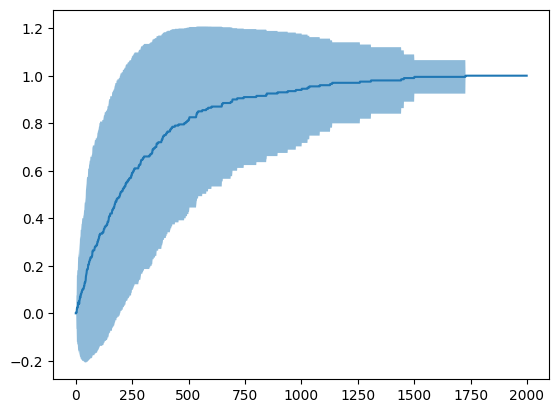

In [6]:
# Training a Q learner initialized on a potential.
import numpy as np
from collections import defaultdict

# Setup experiment
exp = rs.Experiment(
    "ExampleLargeLakeQInit", **big_lake_params, q_learner_params=big_q_learner_params
)

# Create initial qtable based on potential
qtable_init = defaultdict(lambda: np.ones(4))
frozen_potential_big = frozen_potential_function(
    LARGE_MAP_SIZE, big_q_learner_params["discount"] / 2
)
for s in range(LARGE_MAP_SIZE**2):
    qtable_init[s] = qtable_init[s] * frozen_potential_big(s)

# Initialize qtable for experiment
exp.set_initial_qtable(qtable_init)

# Run experiment and plot evaluations
exp.run(runs=RUNS, episodes_per_run=LARGE_EPISODES)
exp.plot_evals()

You may notice a striking similarity with our most recent training run using reward shaping... copied here:

<img src="assets/large-lake-modified-pbrs-evals.png">


In fact, a 2003 [paper](https://arxiv.org/abs/1106.5267) proves that potential based reward shaping is identical to initializing the Q-table at the potential! This offers a new (possibly more flexible) perspective on what we've done in this notebook.

# Resources and References

- [Policy Invariance under Reward Transformations](https://people.eecs.berkeley.edu/~pabbeel/cs287-fa09/readings/NgHaradaRussell-shaping-ICML1999.pdf)
- [Potential-Based Shaping and Q-Value Initialization are Equivalent](https://arxiv.org/abs/1106.5267)